In [1]:
#import os
#os.environ['THEANO_FLAGS'] = 'optimizer=fast_compile'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

In [3]:
from easydict import EasyDict
cfg = EasyDict()
cfg.SEQ_LENGTH = 250
cfg.TILE_SIZE = 16
cfg.OUT_SIZE = 1
cfg.TRAIN = EasyDict()
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.EPOCH_SIZE = 1000
cfg.TRAIN.EPOCH_NUM = 1000
cfg.gm_num = 4
cfg.ndim = 9
cfg.NAME = 'conv_net_color_ndim%i'%(cfg.ndim)#'conv_net_no_bn_ndim12010'#

In [4]:
from loader import TieLoader,data_generator
train_loader = TieLoader('half_ties',0.2,0.3,t_size=32,mask_size=cfg.OUT_SIZE,sample_size=cfg.TILE_SIZE)
test_loader = TieLoader('test/half_ties',0.2,0.3,t_size=32,mask_size=cfg.OUT_SIZE,sample_size=cfg.TILE_SIZE)

204.0 52.0


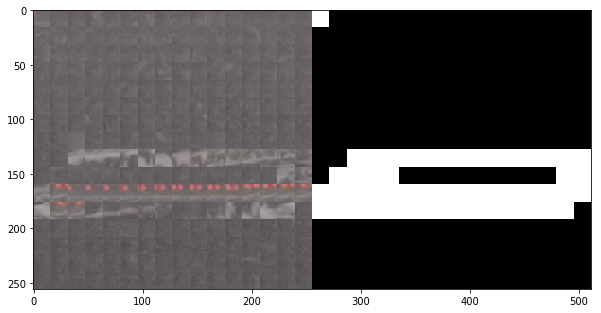

In [5]:
from dataset_tools import draw

for x,y in data_generator(train_loader,epoch_size=1,shuffle=True):
    print np.ones_like(y)[y<0.1].sum(),np.ones_like(y)[y>0.9].sum()
    x = np.transpose(x,(0,2,3,1)).astype(np.uint8)
    y = (y*255.).astype(np.uint8)
    _y = np.zeros(x.shape[:3],dtype=np.uint8)
    _y[:] = y[:,0,0][:,None,None]
    draw(x,_y)

In [6]:
import theano
import theano.tensor as T
from utils import get_network_str,save_weights,load_weights
import lasagne
from lasagne import layers as L
from lasagne.nonlinearities import rectify,tanh
from lasagne.regularization import regularize_network_params,l2
from gmm_op import get_gmm,calc_log_prob_gmm,calc_log_prob_gmm_componetwise
from theano_utils import split,histogram_loss

/usr/local/lib/python2.7/dist-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


# Build model

In [7]:
data = T.tensor4(name='data')
label = T.tensor3(name='label')

def make_conv(data,num_filters,name,nonl = rectify):
    return L.Conv2DLayer(data,filter_size=(3,3),num_filters=num_filters,
                        nonlinearity=nonl,pad='same',
                        name='conv'+str(name))

def make_deconv(data,num_filters,name):
    return  L.Deconv2DLayer(data,12,2,2,crop='valid',name='deconv'+str(name),nonlinearity=rectify)
    
feature_matrix = theano.shared(np.random.rand(cfg.ndim,cfg.ndim).astype(np.float32))
def baseline(data,ndim=cfg.ndim,verbose=True,model_name=''):
    datal = res = L.InputLayer((None,3,None,None)
                           ,data
                           ,name='data')
    if(model_name != ''):
        load_weights(res,model_name,)
    print get_network_str(res,incomings=True,outgoings=True)
    sym = lasagne.layers.get_output(res)
    sym = T.transpose(sym,(0,2,3,1))/256.
    params = lasagne.layers.get_all_params(res, trainable=True)
    l2_loss = 1e-4 * regularize_network_params(res, l2)
    return res,sym,params,l2_loss,[]

def FCN(data,ndim=cfg.ndim,verbose=True,model_name=''):
    datal = res = L.InputLayer((None,3,None,None)
                           ,data
                           ,name='data')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=6,
                        nonlinearity=rectify,pad='same',
                        name='conv1')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=12,
                        nonlinearity=rectify,pad='same',
                        name='conv2')
    res = L.Conv2DLayer(res,filter_size=(3,3),num_filters=ndim-3,
                        nonlinearity=None,pad='same',
                        name='conv3')
    add_params = []
    if(model_name != ''):
        add_params =  load_weights(res,model_name,1)
        
    print get_network_str(res,incomings=True,outgoings=True)
    sym = lasagne.layers.get_output(res)
    sym = T.transpose(sym,(0,2,3,1))
    
    data = T.transpose(data,(0,2,3,1))/256.
    sym = sym/(T.sqrt(T.square(sym).sum(-1)+1e-8)[:,:,:,None])
    sym = T.concatenate([sym,data],-1)
    sym = T.dot(sym,feature_matrix/(T.sqrt((T.sum(T.square(feature_matrix),0)+1e-5))[None,:]))
    params = lasagne.layers.get_all_params(res, trainable=True)
    params.append(feature_matrix)
    l2_loss = 1e-4 * regularize_network_params(res, l2)
    return res,sym,params,l2_loss,add_params
               

def soft_predict_sym(features,means,covars,weights):
    return 1.-T.nnet.sigmoid(calc_log_prob_gmm(features,means,covars,weights))

# Train

In [8]:
data = T.tensor4(name='data')
label = T.tensor3(name='label')
net,X,params,l2_loss,add_params = FCN(data,ndim=cfg.ndim,model_name='')#models/conv2_net_no_bn_ndim6010')#'models/conv1_net_no_bn_ndim12000')
def get_output(X,t=cfg.TILE_SIZE,o=cfg.OUT_SIZE):
    return X[:,(t-o)//2:(t+o)//2,(t-o)//2:(t+o)//2,:]

X = get_output(X)
X = X.reshape((-1,X.shape[-1]))


In -->     Layer    --> Out    Description                
-------    -----    -------    -----------                
[]         0        [1]        data(None, 3, None, None)  
[0]        1        [2]        conv1(None, 6, None, None) 
[1]        2        [3]        conv2(None, 12, None, None)
[2]        3        []         conv3(None, 6, None, None) 


In [9]:
min_cov = theano.shared(1e-3)
p_p_weight = theano.shared(0.)
p_n_weight = theano.shared(0.)

In [9]:
feature_matrix.set_value(add_params[0])

IndexError: list index out of range

In [10]:
def make_train_fn(net,X,params,l2_loss,model_name=''):
    def split_tr_p_n(x,y):
        x_tr_p,x_n = split(x,y)
        x_p = x_tr_p[x_tr_p.shape[0]//2:]
        x_tr = x_tr_p[:x_tr_p.shape[0]//2]
        return x_tr,x_p,x_n
    x_tr,x_p,x_n = split_tr_p_n(X,label.flatten())    
    m,c,w = get_gmm(x_tr,cfg.gm_num,cfg.ndim,use_approx_grad=True)
    
    p_n = calc_log_prob_gmm(x_n,m,c,w)
    p_p = calc_log_prob_gmm(x_p,m,c,w)
    loss = histogram_loss(p_n,p_p,min_cov,70)[0]+l2_loss-\
            T.mean(T.clip(p_p,-100,40))*p_p_weight+\
            p_n_weight*(T.mean(T.clip(p_n,-40,100)))
    prediction = T.nnet.sigmoid(T.concatenate([p_p,p_n],axis=0))
    Y = T.concatenate([T.ones_like(p_p),T.zeros_like(p_n)],axis=0)
    G_lr = theano.shared(np.array(1e-3, dtype=theano.config.floatX))
    updates = lasagne.updates.adam(loss,params,G_lr)
    train_fn = theano.function([data, label], [loss,X,Y,prediction,m,c,w],\
                               allow_input_downcast=True, updates=updates)
    print 'train_fn compiled'
    test_fn = theano.function([data, label], [loss,X,Y,prediction,m,c,w,p_p,p_n],\
                               allow_input_downcast=True)
    print 'test_fn compiled'
    return train_fn,test_fn,G_lr,net

train_fn,test_fn,G_lr,net=make_train_fn(net,X,params,l2_loss)

train_fn compiled
test_fn compiled


обучать и естировать на одних роликах
выбор threshold


In [11]:
G_lr.set_value(np.float32(.01))

In [12]:
hard = []
cur = 0

In [14]:
min_cov.set_value(1e-8)
p_p_weight.set_value(0.)
p_n_weight.set_value(10.)

In [15]:
from sklearn.metrics import average_precision_score

def get_pp_pn(l,pred):
    o = np.ones(len(l))
    pn = []
    pp = []
    R = pred[::max(len(pred)//100,1)].copy()
    R  = np.sort(R)
    for r in R:
        pn.append(o[(pred > r)&(l>0.9)].sum()/o[l>0.9].sum())
        pp.append(o[(pred < r)&(l<0.1)].sum()/o[l<0.1].sum())
    pp,pn = np.array(pp),np.array(pn)
    return (np.abs(pn[1:]-pn[:-1])*(pp[1:]+pp[:-1])/2.).sum()

metrix = { 'aps' : average_precision_score,
           'pp'  : lambda l,pred : np.ones(len(l))[(pred < 0.5)&(l<0.1)].sum()/np.ones(len(l))[l<0.1].sum(),
           'pn'  : lambda l,pred : np.ones(len(l))[(pred >= .5)&(l>0.9)].sum()/np.ones(len(l))[l>0.9].sum(),
           'int_pp_pn' : lambda l,pred : get_pp_pn(l,pred)}

def iterate_batches(fn,data_generator,epoch,metrix = dict()):
    loss=0
    acc=0
    labels,predicted = np.array([]),np.array([])
    for i,batch in enumerate(data_generator()):        
        res = fn(*batch)
        mask = (res[2]>0.9) | (res[2]<0.1)
        loss+=res[0]
        labels = np.concatenate((labels,res[2][mask]))
        predicted = np.concatenate((predicted,res[3][mask]))
        s = ' '.join(['%s=%.3f'%(k,metrix[k](labels,predicted)) for k in metrix.keys() ])
        print '\r epoch %i batch %i loss=%.2f l=%.2f %s     '%\
        (epoch,i,loss/float(i+1),res[0],s),
    print ''
    for k in metrix.keys():
        print '%s=%.3f'%(k,metrix[k](res[2][mask],res[3][mask])),
    print ''

for j in range(0,15):
    print('train')
    iterate_batches(train_fn,\
                    lambda : data_generator(train_loader,epoch_size=500,shuffle=True),
                   j,metrix)
    save_weights(net,'models/%s%03d'%(cfg.NAME,j),[feature_matrix.get_value()])
    print('test')
    iterate_batches(test_fn,\
                    lambda : data_generator(test_loader,epoch_size=200,shuffle=True),
                   j,metrix)

train
 epoch 0 batch 499 loss=141.85 l=-399.99 aps=0.992 pp=0.953 pn=0.950 int_pp_pn=0.973                                                                                                                                                                                                        
aps=1.000 pp=1.000 pn=0.755 int_pp_pn=1.000 
checkpoint models/conv_net_color_ndim9000.npz
test
 epoch 0 batch 199 loss=182.65 l=-399.99 aps=0.992 pp=0.966 pn=0.912 int_pp_pn=0.975                                                          
aps=1.000 pp=1.000 pn=1.000 int_pp_pn=0.995 
train
 epoch 1 batch 499 loss=100.88 l=2002.08 aps=0.993 pp=0.959 pn=0.947 int_pp_pn=0.979                                                                                                                                                                                                     
aps=0.946 pp=0.981 pn=0.510 int_pp_pn=0.890 
checkpoint models/conv_net_color_ndim9001.npz
test
 epoch 1 batch 199 loss=217.95 l=-338.87 

KeyboardInterrupt: 

In [18]:
np.set_printoptions(2)
print np.abs(feature_matrix.get_value()).mean(1)

 [ 0.51  0.64  0.63  0.68  0.56  0.63  0.74  0.43  0.7 ]


если обучать норм фичи + цвета/256 

heckpoint models/conv3_net_with_color_ndim9000.npz

epoch 1 batch 91 loss=506.94 ,acc=0.99,pp=0.93,pn=0.94, l=450.83 a=1.00 

test batch 199 loss=751.01 ,acc=0.00,pp=0.87,pn=0.94, l=1003.61 a=0.00, 


норм все

 batch 499 loss=1006.93 ,acc=0.98,pp=0.72,pn=0.98, l=531.66 a=1.00
 
 test batch 199 loss=1218.88 ,acc=0.00,pp=0.59,pn=0.98, l=610.84 a=0.00,,

In [22]:
for i,batch in enumerate(data_generator(test_loader,epoch_size=100,shuffle=False)):
    res = test_fn(*batch)
    if(i == 0):
        p =res[-1]
        n = res[-2]
    p = np.concatenate((p,res[-1]))
    n = np.concatenate((n,res[-2]))
    

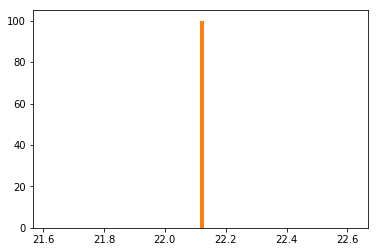

In [23]:
plt.hist(np.clip(res[-1],-10,100),100,normed=True)
plt.hist(np.clip(res[-2],-10,100),100,normed=True)
plt.show()

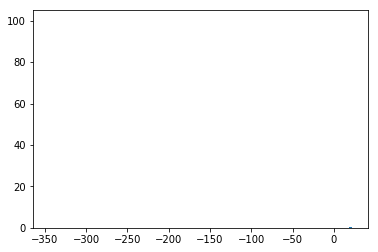

In [25]:
plt.hist(p,100,normed=True)
plt.hist(n,100,normed=True)
plt.show()

# Evaluate model

In [18]:
data=T.tensor4()
feature_sym = FCN(data,model_name='models/'+cfg.NAME+'000')[1]
feature_fn = theano.function([data],feature_sym,allow_input_downcast=True)


In -->     Layer    --> Out    Description                
-------    -----    -------    -----------                
[]         0        [1]        data(None, 3, None, None)  
[0]        1        [2]        conv1(None, 6, None, None) 
[1]        2        [3]        conv2(None, 12, None, None)
[2]        3        []         conv3(None, 6, None, None) 


In [19]:
from dataset_tools import *
from gmm_bg_substructor import BgSubstructor
import cv2
import numpy as np
# params = { 'algorithm': 'grimson_gmm', 
#             'low': 1.,#*24*24,
#             'high': 3,#.*24*24,
#             'alpha': 0.01,
#             'max_modes': 5,
#             'channels': 12,
#             'variance': .01,
#             'bg_threshold': 0.075,
#             'min_variance': .005,
#             'variance_factor': 1.}


In [20]:
def make_bgs_test(feature_fn,params,out_name=cfg.NAME,dataset='test_dataset',max_l = 1000,im_size=None,verbose=False,skip_frames=200):
    def make_bgs_features(feature_fn,x):
        return feature_fn(np.transpose(x,(0,3,1,2)))[0]
    out_dir = 'results/'+out_name+'_'+params['algorithm']
    if(not os.path.exists(out_dir)):
        os.mkdir(out_dir)
    f = open('params.txt','w')
    f.write('params\n'+str(params)+'\n')
    f.write('max_l = %i,skip_frames=%i')
    f.close()
    jj = 0
    try:
        for d_in,d_out in iterate_folders(dataset,out_dir):
            jj+=1
            if(jj<1):
                continue
            try:
                bgs = BgSubstructor(params)
                i = 0
                prev =None
                for im,mask in iterate_video(d_in,skip_first_unlabled=True):
                    print '%s %d                   \r'%(d_in,i),
                    if not (im_size is None):
                        im,mask = resize(im,mask,im_size)
                    if(prev is None):
                        prev = im
                        continue
                    tmp = np.concatenate((im[np.newaxis],prev[np.newaxis]),0)
                    features = make_bgs_features(feature_fn,tmp.astype(np.float32))
                    prev = im
                    pred = bgs.update(features.astype(np.float32),im.astype(np.float32))
                    cv2.imwrite(d_out+'/%d.png'%(i),pred)
                    cv2.imwrite(d_out+'/%d_true.png'%(i),mask)
                    cv2.imwrite(d_out+'/%d_input.png'%(i),im)
                    if(verbose):
                        cv2.imshow('pred',pred)
                        cv2.imshow('true',mask)
                        cv2.imshow('input',im)
                        cv2.waitKey(1)
                    if(i >= max_l):
                        break
                    i+=1
                print '%s %d\r'%(d_in,i),
            finally:
                del bgs
    finally:
        if(verbose):
            cv2.destroyAllWindows()
    print 'done'

In [30]:
params = { 
    'algorithm': 'FTSG', 
    'th': 30, 
    'nDs': 5,
    'nDt': 5,
    'nAs': 5,
    'nAt': 5,
    'bgAlpha': 0.004,
    'fgAlpha': 0.05,
    'tb': 15,
    'tf': 0.00001,
    'tl': 0.01,
    'init_variance' : 0.01
} 
make_bgs_test(feature_fn,
               out_name=cfg.NAME,
               params=params,
               dataset='../gmm_segmentation/test_dataset',
               im_size=(320,240),
               verbose=True)

delete bgsmentation/test_dataset/badWeather/blizzard 1000                   
delete bgsmentation/test_dataset/baseline/highway 162                   


KeyboardInterrupt: 

In [20]:
params = { 
    'algorithm': 'FTSG', 
    'th': 30, 
    'nDs': 5,
    'nDt': 5,
    'nAs': 5,
    'nAt': 5,
    'bgAlpha': 0.004,
    'fgAlpha': 0.5,
    'tb': 4,
    'tf': 20,
    'tl': 0.1,
    'init_variance': 15
}
make_bgs_test(lambda x : np.transpose(x,(0,2,3,1)),
               params,
               out_name='baseline',
               dataset='../gmm_segmentation/test_dataset',
               im_size=(320,240),
               verbose=True)

delete bgsmentation/dataset/badWeather/skating 1000                   
delete bgsmentation/dataset/badWeather/snowFall 1000                   
delete bgsmentation/dataset/badWeather/wetSnow 0                   
delete bgsmentation/dataset/baseline/office 1000                   
delete bgsmentation/dataset/baseline/pedestrians 799                   
delete bgsmentation/dataset/baseline/PETS2006 223                   


KeyboardInterrupt: 

In [45]:
data,m,c,w=T.matrix(),T.matrix(),T.matrix(),T.vector()
predict_fn = theano.function([data,m,c,w],soft_predict_sym(data,m,c,w),allow_input_downcast=True)

# Find parameters for grimpson gmm

In [26]:
from test_tools import make_features,make_gmms,fit_gmms,predict_pixelwise
from dataset_tools import *


def find_gmm_params(feature_fn,
              dataset='../gmm_segmentation/test_dataset',
              max_frames=300,
              im_size = (320//2,240//2)):
    all_covars = []
    all_weights = []
    all_comp = []
    all_masks = []
    for k,in_dir in enumerate(iterate_folders(dataset)):
        for i,(imgs,masks) in enumerate(iterate_bathced(in_dir,max_frames,im_size)):
            print in_dir,'generate_features,',
            data = make_features(feature_fn,imgs)
            gmms = make_gmms(imgs.shape[1:-1],cfg.gm_num)
            print 'fit gmms'
            fit_gmms(data,gmms,None)
            cov = np.empty((len(gmms),)+gmms[0].covariances_.shape,dtype=np.float32)
            weights = np.empty((len(gmms),len(gmms[0].weights_)),dtype=np.float32)
            dists = np.empty((len(gmms),len(imgs),len(gmms[0].weights_)),dtype=np.float32)
            data = data.reshape((len(imgs),-1,gmms[i].means_.shape[1]))
            for j in range(len(gmms)):
                cov[j] = gmms[j].covariances_
                weights[j] = gmms[j].weights_
                dists[j] = ((data[:,j,None,:]-gmms[j].means_[None,:,:])**2).sum(-1)
            print 'cov',cov.mean(),cov.std()
            masks = masks.reshape((len(masks),-1))
            masks = np.transpose(masks,(1,0))
            print 'cov bg',dists[masks < 0.5].min(-1).mean(),dists[masks < 0.1].min(-1).std()
            print 'cov motion',dists[masks > 0.5].min(-1).mean(),dists[masks > 0.9].min(-1).std()
            print 'std motion',data[masks > 0.9].std()
            break
    print 'test complete'
    
    
find_gmm_params(feature_fn,max_frames=70,im_size=(50,30))

../gmm_segmentation/test_dataset/badWeather/blizzard generate_features,

IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
from test_tools import make_features,make_gmms,fit_gmms,predict_pixelwise
from dataset_tools import *
def make_test_as_train(feature_fn,predict_fn,
              out_dir='results/'+cfg.NAME,
              dataset='dataset',
              max_frames=300,
              im_size = (320//2,240//2)):
    for in_dir,out_dir in iterate_folders(dataset,out_dir):
        for i,(imgs,masks) in enumerate(iterate_bathced(in_dir,max_frames,im_size)):
            if(masks[(masks>30) & (masks < 240)].size > 0.1*masks.size):
                continue
            print in_dir,'generate_features,',
            data = make_features(feature_fn,imgs)
            gmms = make_gmms(imgs.shape[1:-1],cfg.gm_num)
            print 'fit gmms,',
            fit_gmms(data[:100],gmms,masks[:100])
            print 'predict,',
            prediction = predict_pixelwise(data[100:],gmms,predict_fn)
            print 'save'
            imgs = imgs[100:]
            masks = masks[100:]      
            prediction = (prediction*255).astype(np.uint8)
            for i in range(len(imgs)):
                cv2.imwrite(out_dir+'/'+str(i)+'.png',prediction[i])
                cv2.imwrite(out_dir+'/'+str(i)+'_true.png',masks[i])
                cv2.imwrite(out_dir+'/'+str(i)+'_input.jpg',imgs[i])
            break
            print ''
    print 'test complete'

In [46]:
make_test_as_train(feature_fn,predict_fn,
                   out_dir='results/'+cfg.NAME+'_tat',
                   dataset='../gmm_segmentation/test_dataset')

../gmm_segmentation/test_dataset/badWeather/blizzard generate_features,

IndexError: index 0 is out of bounds for axis 0 with size 0

# Calc metric

In [31]:
from sklearn.metrics import average_precision_score
import os

def calc_metrics_imgs(predict,label):
    predict,label = predict.flatten(),label.flatten()
    mask = (label>230)|(label < 50)
    p = (predict.astype(np.float32)/255.)[mask]
    y = (label.astype(np.float32)/255.)[mask]
    y[y>0.5] = 1.
    y[y<=0.5] = 0.
    bp = np.zeros_like(p)
    bp[p>0.5] = 1.
    TP = (bp*y).sum()
    TN = ((1-bp)*(1-y)).sum()
    FP = (bp*(1.0-y)).sum()
    FN = ((1.0-bp)*y).sum()
    AveragePrecision = 0#average_precision_score(y,p)
    return np.array([TP,TN,FP,FN],dtype=np.int64),AveragePrecision
    

def print_results(results):
    s = ''
    for k in results.keys():
        s=s+k+str(': ')+str(results[k])+'\n'
    return s

def calc_metrics_folder(data_dir):
    S = np.array([0,0,0,0],dtype=np.int64)
    AveragePrecision = 0.0
    nums = [int(i[:-4]) for i in os.listdir(data_dir) if i.find('true') < 0 and  i.find('input') < 0]
    for i in nums:
        m = cv2.imread(data_dir+'/%i_true.png'%(i))
        p = cv2.imread(data_dir+'/%i.png'%(i))
        cv2.imshow('p',p)
        cv2.waitKey(1)
        _s = calc_metrics_imgs(p,m)
        AveragePrecision += _s[1]
        S+=_s[0]
        
    TP,TN,FP,FN = S[0],S[1],S[2],S[3]
    if(S.min() <= 0):
        results = dict( AveragePrecision = 0,\
                        Recall = np.nan,\
                        Sp = np.nan,\
                        FPR = np.nan,\
                        FNR = np.nan,\
                        PWC =  np.nan,\
                        F_Measure  =  np.nan,\
                        Precision  = np.nan)
    else:
        results = dict( AveragePrecision = AveragePrecision/float(len(nums)),\
                        Recall = TP / float(TP + FN),\
                        Sp = TN / float(TN + FP),\
                        FPR = FP / float(FP + TN),\
                        FNR = FN / float(TP + FN),\
                        PWC =  100 * (FN + FP) / float(TP + FN + FP + TN),\
                        F_Measure  =  (2 * (TP / float(TP + FP)) * (TP / float(TP + FN))) / (TP / float(TP + FP) +  TP / float(TP + FN)),\
                        Precision  = TP / float(TP + FP))

    print data_dir
    print print_results(results)
    return results

def calc_metric_all_folders(data_dir):
    res = []
    f = open(data_dir+'.txt','w')
    list_dirs = []
    for j in os.listdir(data_dir):
        list_dirs = list_dirs+[data_dir+'/'+j+'/'+i for i in os.listdir(data_dir+'/'+j)]
    
    for folder in list_dirs:
        results = calc_metrics_folder(folder)
        if not (results is None):
            res.append(results)
            f.write(folder+'\n')
            f.write(print_results(results))
    results = dict()
    for k in res[0].keys():
        results[k] = np.array([i[k] for i in res if np.isfinite(i[k])]).mean()
    f.write('total result\n')
    f.write(print_results(results))
    f.close()
    print 'total result'
    print print_results(results)

calc_metric_all_folders('results/'+cfg.NAME+'_FTSG')

results/conv3_net_with_color_ndim9_FTSG/badWeather/blizzard
AveragePrecision: 0.0
FNR: 0.444309717241
Recall: 0.555690282759
Sp: 0.99906276319
Precision: 0.909148756021
PWC: 0.829626546017
FPR: 0.000937236810338
F_Measure: 0.68977562166

results/conv3_net_with_color_ndim9_FTSG/baseline/highway
AveragePrecision: 0.0
FNR: 0.0708977856914
Recall: 0.929102214309
Sp: 0.9763472231
Precision: 0.697455851039
PWC: 2.62717720708
FPR: 0.0236527769002
F_Measure: 0.796784067397

total result
AveragePrecision: 0.0
FNR: 0.257603751466
Recall: 0.742396248534
Sp: 0.987704993145
Precision: 0.80330230353
PWC: 1.72840187655
FPR: 0.0122950068552
F_Measure: 0.743279844529



In [5]:
import pandas as pd
def parse_results(dir_results):
    for i  in os.listdir(dir_results):
        